In [ ]:
def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 3
    while True:
        yield(np.array([(x, random.uniform(0, 1)) for _ in range(batch_size)]))


def distribution2(batch_size=512):
    # High dimension uniform distribution
    while True:
        yield(np.random.uniform(0, 1, (batch_size, 2)))


def distribution3(batch_size=512):
    # 1D gaussian distribution
    while True:
        yield(np.random.normal(0, 1, (batch_size, 1)))

e = lambda x: np.exp(x)
tanh = lambda x: (e(x) - e(-x)) / (e(x)+e(-x))
def distribution4(batch_size=1):
    # arbitrary sampler
    f = lambda x: tanh(x*2+1) + x*0.75
    while True:
        yield(f(np.random.normal(0, 1, (batch_size, 1))))

In [ ]:
#Importer les dossiers
#import density_estimation as de
#import samplers as sm

#Importer les bibliothèques de python
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [ ]:
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.D = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
        self.D.apply(xavier_init)
    def forward(self,input):
        return self.D(input)

In [ ]:
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class WNet(nn.Module):
    def __init__(self):
        super(WNet,self).__init__()
        self.D = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
        self.D.apply(xavier_init)
    def forward(self,input):
        return self.D(input)

In [ ]:
D = Net()
T = Net()

In [ ]:
def loss_fn1(Discriminator,x,y):
    x = x.to('cuda')
    y = y.to('cuda')
    real_data = torch.mean(torch.log(Discriminator(x)))
    fake_data = torch.mean(torch.log(1 - Discriminator(y)))
    return -(real_data+fake_data)

In [ ]:
def loss_fn2(Discriminator,x,y,lamb=10):
    x = x.to('cuda')
    y = y.to('cuda')
    real_data = torch.mean(Discriminator(x))
    #print("D_real:",real_data)
    fake_data = torch.mean(Discriminator(y))
    #print("D_fake:",real_data)
    a = torch.empty(512, 1).uniform_(0, 1).float().cuda()
    #p = torch.from_numpy(next(sm.distribution1(0))).float()
    #q = torch.from_numpy(next(sm.distribution1(-1))).float()
    
    z = a*x+(1-a)*y
    input = torch.autograd.Variable(z,requires_grad= True)
    output = Discriminator(input)
    grad = torch.autograd.grad(output, input, grad_outputs=torch.ones(output.size()).cuda(),create_graph=True, only_inputs=True, 
    					   retain_graph=True)[0]
    grad = grad.view(512, -1)
    grad = grad.norm(2,dim =1)
    grad = grad - 1
    grad = grad**2
    #grad = torch.sqrt(grad)
    return -(real_data-fake_data-lamb*grad.mean())

In [ ]:
a,b,thet = [],[],[]
cuda = torch.cuda.is_available();
for i in range(21):
    T = WNet().cuda()
    theta = -1 + i*0.1
    thet.append(theta)
    p = distribution1(0, 512)
    q = distribution1(theta,512)
    dist_p = iter(p)
    dist_q = iter(q)
#		dist_q = iter(q)
    optimizer = optim.Adam(T.parameters(), lr=1e-3)
    print('theta:', thet)
    for i in range(5000):
        T.train()
        X = torch.from_numpy(next(dist_p)).float()
        Y = torch.from_numpy(next(dist_q)).float()
        loss = loss_fn2(T,X,Y)
        if ( i%1000 == True):
          print(-loss.data)
        T.zero_grad()
        loss.backward()
        optimizer.step()
    T.eval()
    X = torch.from_numpy(next(dist_p)).float()
    Y = torch.from_numpy(next(dist_q)).float()
    b.append(-loss_fn2(T,X,Y))

theta: [-1.0]
tensor(-8.2364, device='cuda:0')
tensor(1.0247, device='cuda:0')
tensor(1.0249, device='cuda:0')
tensor(1.0258, device='cuda:0')
tensor(1.0258, device='cuda:0')
theta: [-1.0, -0.9]
tensor(-4.7980, device='cuda:0')
tensor(0.9209, device='cuda:0')
tensor(0.9213, device='cuda:0')
tensor(0.9204, device='cuda:0')
tensor(0.9206, device='cuda:0')
theta: [-1.0, -0.9, -0.8]
tensor(-4.6533, device='cuda:0')
tensor(0.8162, device='cuda:0')
tensor(0.8161, device='cuda:0')
tensor(0.8163, device='cuda:0')
tensor(0.8141, device='cuda:0')
theta: [-1.0, -0.9, -0.8, -0.7]
tensor(-6.0719, device='cuda:0')
tensor(0.7122, device='cuda:0')
tensor(0.7123, device='cuda:0')
tensor(0.7126, device='cuda:0')
tensor(0.7123, device='cuda:0')
theta: [-1.0, -0.9, -0.8, -0.7, -0.6]
tensor(-5.3287, device='cuda:0')
tensor(0.6088, device='cuda:0')
tensor(0.6089, device='cuda:0')
tensor(0.6093, device='cuda:0')
tensor(0.6093, device='cuda:0')
theta: [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5]
tensor(-7.4934, devic

In [ ]:
a,thet = [],[]
cuda = torch.cuda.is_available();
for i in range(21):
    D = Net().cuda()
    theta = -1 + i*0.1
    thet.append(theta)
    p = distribution1(0, 512)
    q = distribution1(theta,512)
    dist_p = iter(p)
    dist_q = iter(q)
#	dist_q = iter(q)
    optimizer = optim.Adam(D.parameters(), lr=1e-3)
    print(thet)
    for i in range(5000):
        D.train()
        X = torch.from_numpy(next(dist_p)).float()
        Y = torch.from_numpy(next(dist_q)).float()
        loss = loss_fn1(D,X,Y)
        
        D.zero_grad()
        if ( i%1000 == True):
          print(-loss.data)
        loss.backward()
        optimizer.step()
    D.eval()
    X = torch.from_numpy(next(dist_p)).float()
    Y = torch.from_numpy(next(dist_q)).float()
    a.append(-loss_fn1(D,X,Y)/2+np.log(2))
    #b.append(-loss_fn2(T,p,q))

[-1.0]
tensor(-1.2429, device='cuda:0')
tensor(-0.0011, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-6.6795e-05, device='cuda:0')
tensor(-3.1449e-05, device='cuda:0')
[-1.0, -0.9]
tensor(-1.4331, device='cuda:0')
tensor(-0.0012, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-9.6545e-05, device='cuda:0')
tensor(-4.0631e-05, device='cuda:0')
[-1.0, -0.9, -0.8]
tensor(-1.3432, device='cuda:0')
tensor(-0.0009, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-6.5357e-05, device='cuda:0')
tensor(-2.9523e-05, device='cuda:0')
[-1.0, -0.9, -0.8, -0.7]
tensor(-1.4464, device='cuda:0')
tensor(-0.0011, device='cuda:0')
tensor(-0.0002, device='cuda:0')
tensor(-8.2210e-05, device='cuda:0')
tensor(-3.1516e-05, device='cuda:0')
[-1.0, -0.9, -0.8, -0.7, -0.6]
tensor(-1.3831, device='cuda:0')
tensor(-0.0006, device='cuda:0')
tensor(-9.6786e-05, device='cuda:0')
tensor(-3.4195e-05, device='cuda:0')
tensor(-1.5000e-05, device='cuda:0')
[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5]

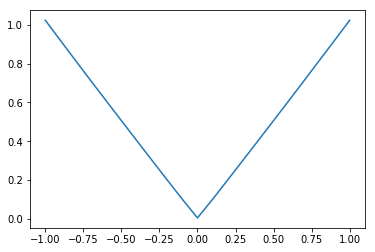

In [ ]:
#plt.plot(thet,a)
plt.plot(thet,b)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad as torch_grad
import samplers as samplers

cuda = torch.cuda.is_available();

class Net(nn.Module):
    def __init__(self, X_dim=2, h_dim= 32):
        super(Net, self).__init__()
        self.X_dim = X_dim
        self.h_dim = h_dim
        self.D = torch.nn.Sequential(
			    torch.nn.Linear(X_dim, h_dim),
			    torch.nn.ReLU(),
			    torch.nn.Linear(h_dim, h_dim),
			    torch.nn.ReLU(),
			    torch.nn.Linear(h_dim, 1),
			)
        self.D.apply(self.init_weights)	

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        return self.D(x)

def loss_WD(Discriminator, X, Y):
	lam = 10
	D_loss_real = torch.mean(Discriminator(X))
	D_loss_fake = torch.mean(Discriminator(Y))
	regularizer = gradient_penalty(Discriminator, X, Y)
	regularizer = lam * (regularizer)
	D_loss = -(D_loss_real - D_loss_fake - (regularizer))
	return D_loss

def gradient_penalty(Discriminator, X, Y):
	batch_size = X.size()[0]
	a = torch.empty(512,1).uniform_(0,1).cuda()
	z = a * X + (1-a) * Y
	z = Variable(z, requires_grad= True)

	prob_z = Discriminator(z)

	# Calculate gradients of probabilities with respect to examples
	gradients = torch_grad(outputs=prob_z, inputs=z, 
							grad_outputs=torch.ones(prob_z.size()).cuda() if cuda else torch.ones(prob_z.size()),
		                   create_graph=True, only_inputs=True, 
    					   retain_graph=True)[0]
	gradients = gradients.view(batch_size, -1)
	return ((gradients.norm(2, dim=1)-1) **2).mean()


## ----------------
## Training 
## ----------------


def train_WD():
	losses = []
	thetas = np.array(range(-10, 11))/10
	p = samplers.distribution1(0, 512)

	for i in range(len(thetas)):
		if cuda:
			Discriminator = Net().cuda()
		else:
			Discriminator = Net()

		p = samplers.distribution1(0, 512)
		q = samplers.distribution1(thetas[i], 512)
		dist_p = iter(p)
		dist_q = iter(q)		
		optimizer = optim.Adam(Discriminator.parameters(), lr = 1e-3)

		print('theta:', thetas[i])
		
		#  training stage
		for e in range(5000):
			Discriminator.train()
			X = torch.from_numpy(next(dist_p)).float()
			Y = torch.from_numpy(next(dist_q)).float()

			if cuda:
				X = X.cuda()
				Y = Y.cuda()

			optimizer.zero_grad()

			loss = loss_WD(Discriminator, X,Y)
			if ( e%1000 == True):
				print(-loss.data)

			loss.backward()
			optimizer.step()

		# testing the values
		Discriminator.eval()

		X = torch.from_numpy(next(dist_p)).float()
		Y = torch.from_numpy(next(dist_q)).float()

		if cuda:
			X = X.cuda()
			Y = Y.cuda()

		loss = loss_WD(Discriminator, X,Y)

		print (-loss.data)
		losses.append(-loss)
	print(losses)
	print ('Done...')

	plt.figure()
	plt.plot(thetas,losses)
	plt.title('Wasserstein GAN')
  #plt.show()

train_WD()

ModuleNotFoundError: ignored

In [ ]:
for i in range(1):
    D = Net().cuda()
    thet
    thet.append(theta)
    p = sm.distribution3()
    q = sm.distribution4(batch_size = 512)
    dist_p = iter(p)
    dist_q = iter(q)
#	dist_q = iter(q)
    optimizer = optim.Adam(D.parameters(), lr=1e-3)
    print(thet)
    for i in range(5000):
        D.train()
        X = torch.from_numpy(next(dist_p)).float()
        Y = torch.from_numpy(next(dist_q)).float()
        loss = loss_fn1(D,X,Y)
        
        D.zero_grad()
        if ( i%1000 == True):
          print(-loss.data)
        loss.backward()
        optimizer.step()
    D.eval()

[-1.0, -0.9, -0.8, -0.7, -0.6, -1.0, -1.0]
tensor(-1.3257, device='cuda:0')
tensor(-1.1943, device='cuda:0')
tensor(-1.2063, device='cuda:0')
tensor(-1.2284, device='cuda:0')
tensor(-1.1918, device='cuda:0')


tensor(-1.3588)
tensor(-1.2446)
tensor(-1.2007)
tensor(-1.2364)
tensor(-1.2073)


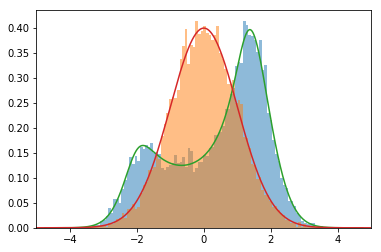

In [ ]:
from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt
import samplers as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
cuda = torch.cuda.is_available()
cuda = False
# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))


############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class WNet(nn.Module):
    def __init__(self):
        super(WNet,self).__init__()
        self.D = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1),
            nn.Sigmoid(),
        )
        self.D.apply(xavier_init)
    def forward(self,input):
        return self.D(input)
D = WNet()
p = sm.distribution3()
q = sm.distribution4(batch_size=512)
dist_p = iter(p)
dist_q = iter(q)

def loss_fn1(Discriminator,x,y):
    x = x.to('cpu')
    y = y.to('cpu')
    real_data = torch.mean(torch.log(Discriminator(x)))
    fake_data = torch.mean(torch.log(1 - Discriminator(y)))
    return -(real_data+fake_data)

optimizer = optim.Adam(D.parameters(), lr=1e-3)

for i in range(5000):
    D.train()
    X = torch.from_numpy(next(dist_p)).float()
    Y = torch.from_numpy(next(dist_q)).float()
    loss = loss_fn1(D,X,Y)
    D.zero_grad()
    if ( i%1000 == True):
        print(-loss.data)
    loss.backward()
    optimizer.step()



In [ ]:
from torch.autograd import Variable
D.eval()
sm.distribution3()
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
f0_x_tensor = Variable(torch.from_numpy(np.float32(xx.reshape(1000, 1))))
#X = torch.from_numpy(next(sm.distribution3(1000))).float().to('cuda')
#print(np.size(np.float32(xx)))
D_x = D(f0_x_tensor)
f1_est = (N(f0_x_tensor) * D_x) / (1 - D_x)

Text(0.5, 1.0, '$D(x)$')

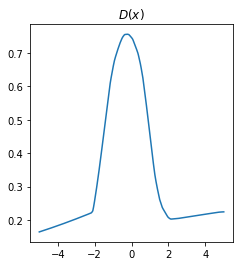

In [ ]:
# Plot the discriminator output.
r = D_x.detach().numpy() 
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')


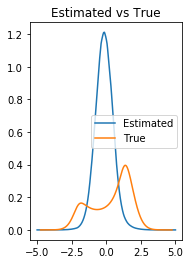

In [ ]:
estimate = f1_est.detach().numpy() 
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')
plt.savefig('Estimated_vs_Exact.png') 
plt.show()
